In [1]:
import os
import pandas as pd
import chardet

# Указываем строку, с которой начинается чтение данных
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Указываем названия колонок
column_names = ['temperature', '3', '10', '5']

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
default_file = file_list[0]

# Определяем кодировку файла
with open(os.path.join(folder_path, default_file), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, default_file),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Вывод первых пяти строк данных
df.head()

,3,10,5
temperature,,,
31.63192,99.99894,99.96317,100.07588
32.58683,99.99902,99.97090,100.04476
33.54175,100.00064,99.97650,100.03758
34.49666,100.00060,99.98113,100.03165
35.45158,99.99498,99.97782,100.03084


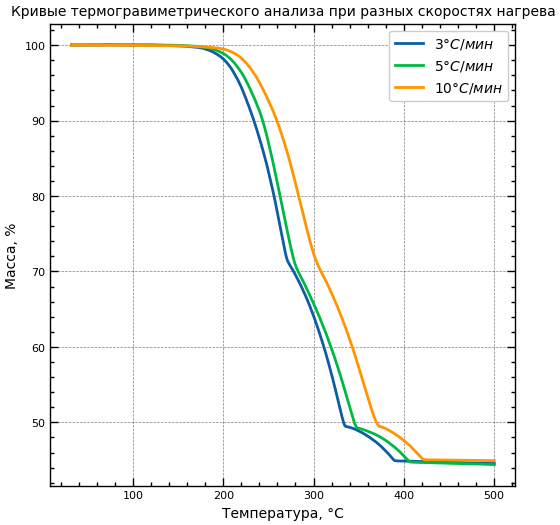

In [2]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа при разных скоростях нагрева', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

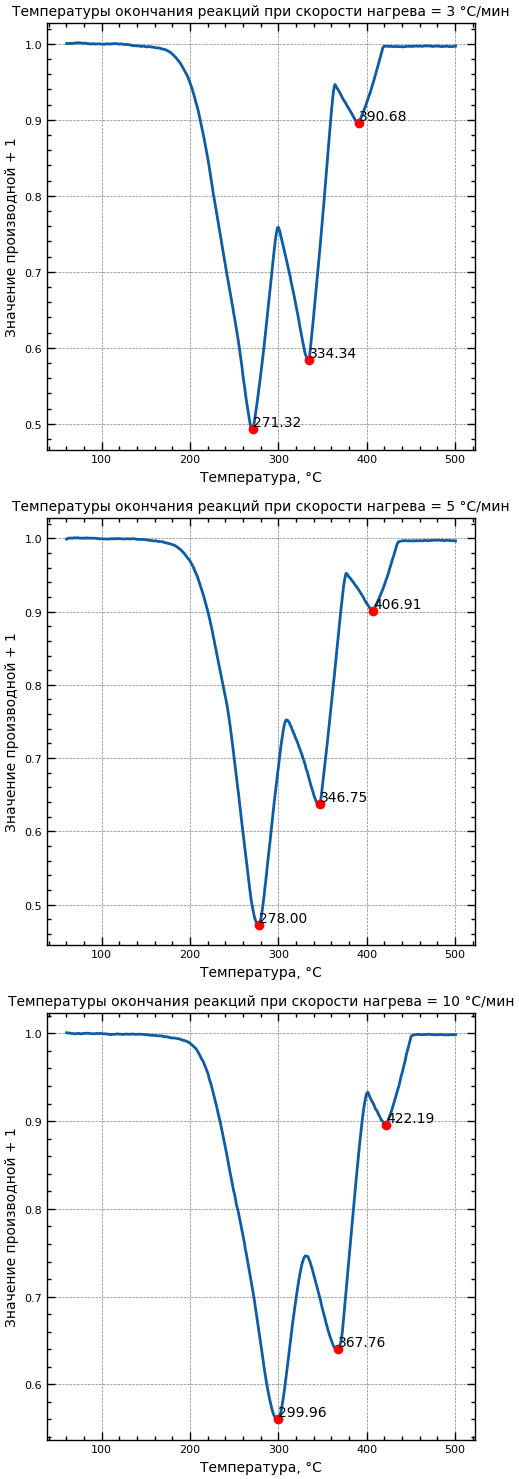

In [3]:
# Определение размера окна для сглаживания
window_size = 30

peaks_df = pd.DataFrame(columns=['начало_реакции', 'первый_пик', 'второй_пик', 'третий пик', 'конец_реакции'])

def find_peaks(df):
    positive_mask = df > 0
    positive_after_negative_mask = positive_mask & (~positive_mask.shift(1, fill_value=True))
    return df[positive_after_negative_mask]

# Создаём фигуру 
fig, axes = plt.subplots(nrows=3, figsize=(5, 15))

heating_rates = ['3', '5', '10']
for idx, heating_rate in enumerate(heating_rates):
    # Сглаживание данных с использованием скользящего среднего
    smoothed_df = df[heating_rate].rolling(window_size).mean()

    # Расчет дифференциала (первой производной) для сглаженных данных
    diff_df = smoothed_df.diff()

    # Более явно подсвечиваем точки перегиба функции
    curve_turn_points = 1 + diff_df

    # Находим температуры при которых реакции начинаются и заканчиваются
    t_start = curve_turn_points[curve_turn_points < 0.985].index.min()
    t_end = curve_turn_points[curve_turn_points < 0.985].index.max()

    # Находим температуры пиков и добавляем в датафрейм
    peaks = find_peaks(curve_turn_points[(curve_turn_points.index > t_start) & (curve_turn_points.index < t_end)].diff())
    peaks_df.loc[heating_rate] = [t_start, peaks.index[0], peaks.index[1], peaks.index[2], t_end]

    axes[idx].plot(df.index, curve_turn_points)

    # Добавляем заголовок
    axes[idx].set_title(f'Температуры окончания реакций при скорости нагрева = {heating_rate} °C/мин', fontsize=MEDIUM_SIZE)

    # Добавляем подписи на оси
    axes[idx].set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    axes[idx].set_ylabel('Значение производной + 1', fontsize=MEDIUM_SIZE)

    # Настраиваем размер легенды и подписей осей
    axes[idx].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Выделяем и подписываем точки на графике
    for index in peaks.index:
        peak_value = curve_turn_points[index]
        axes[idx].plot(index, peak_value, 'ro')
        axes[idx].text(index, peak_value, f'{index:.2f}', fontsize=10, ha='left', va='bottom')

plt.tight_layout()
plt.show()


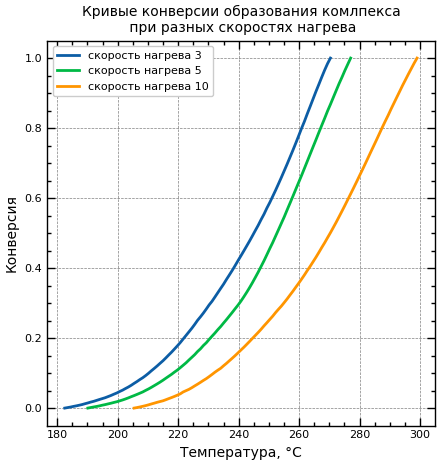

In [5]:
# Создаём фигуру 
fig, axes = plt.subplots(figsize=(5, 5))

heating_rates = ['3', '5', '10']
for heating_rate in heating_rates:
    mass = (df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].values.max()
            - df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].values)

    temperature = df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].index

    conversion = (mass - mass.min()) / (mass.max() - mass.min())
    axes.plot(temperature, conversion, label=f'скорость нагрева {heating_rate}')
    
# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые конверсии образования комлпекса\n при разных скоростях нагрева', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper left', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

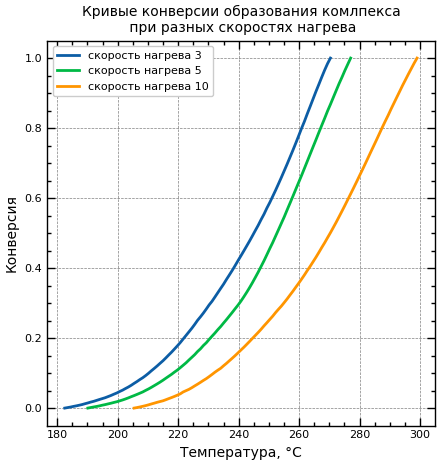

In [6]:
# Создаём фигуру 
fig, axes = plt.subplots(figsize=(5, 5))

heating_rates = ['3', '5', '10']
for heating_rate in heating_rates:
    mass = (df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].values.max()
            - df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].values)

    temperature = df[(df.index > peaks_df['начало_реакции'][heating_rate]) & (df.index < peaks_df['первый_пик'][heating_rate])][heating_rate].index

    conversion = (mass - mass.min()) / (mass.max() - mass.min())
    axes.plot(temperature, conversion, label=f'скорость нагрева {heating_rate}')
    
# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые конверсии образования комлпекса\n при разных скоростях нагрева', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper left', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()